# (28) Eval

**Motivation**: Load models, evaluate. Also, load trainer object and continue training from a checkpoint. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from model.train_vae import TrainerVAE, ConfigTrain
from model.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Load model

In [2]:
%%time

from model.utils_model import load_model

model_name = 'k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'ClipVal:500_AdamaxFast(eps:1e-8)_ep2000-b512-lr(0.003)_beta(0.25)-anneal(1x0.3)_lambda(0.001)_grad(1000)_(2023_03_30,17:53)'
tr, metadata = load_model(
    model_name=model_name,
    fit_name=fit_name,
    device='cuda:1',
    verbose=True,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  17.0 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |   96.0 K   |
|  enc_tower  |  9.4 Mil   |
|     enc0    |   16.6 K   |
| enc_sampler |  1.4 Mil   |
| dec_sampler |  1.4 Mil   |
|    expand   |   71.0 K   |
|  dec_tower  |  4.5 Mil   |
|     post    |   40.0 K   |
|     out     |    578     |
+-------------+------------+

# params: 17.0 M

CPU times: user 58.7 s, sys: 4.5 s, total: 1min 3s
Wall time: 13.8 s


In [3]:
print(list(metadata.items())[:2])

[('checkpoint', 1100), ('global_step', 85800)]

In [4]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 4min 15s, sys: 6.39 s, total: 4min 22s
Wall time: 4min 13s


In [5]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{
    'kl': {'vae': 41.08, 'ema': 40.18},
    'epe': {'vae': 2.62, 'ema': 2.15},
    'l1': {'vae': 3.33, 'ema': 2.74},
    'l2': {'vae': 0.55, 'ema': 0.43}
}

fig/sample (VAE)

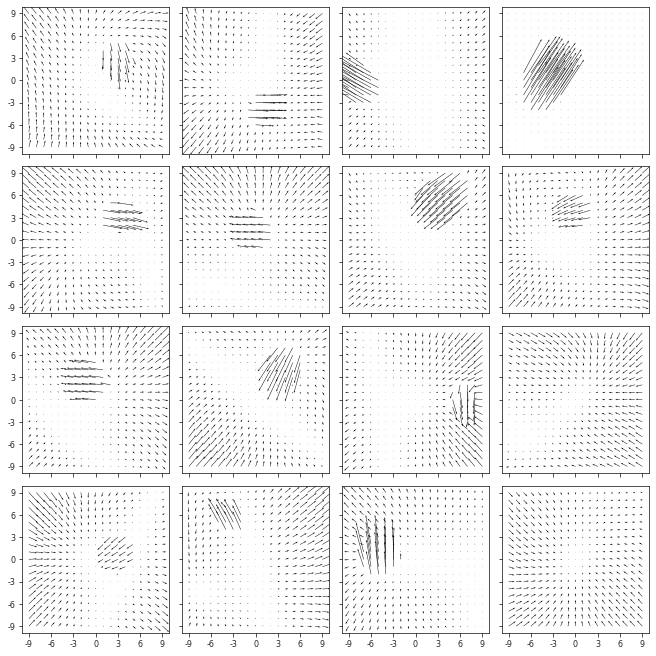

fig/sample (EMA)

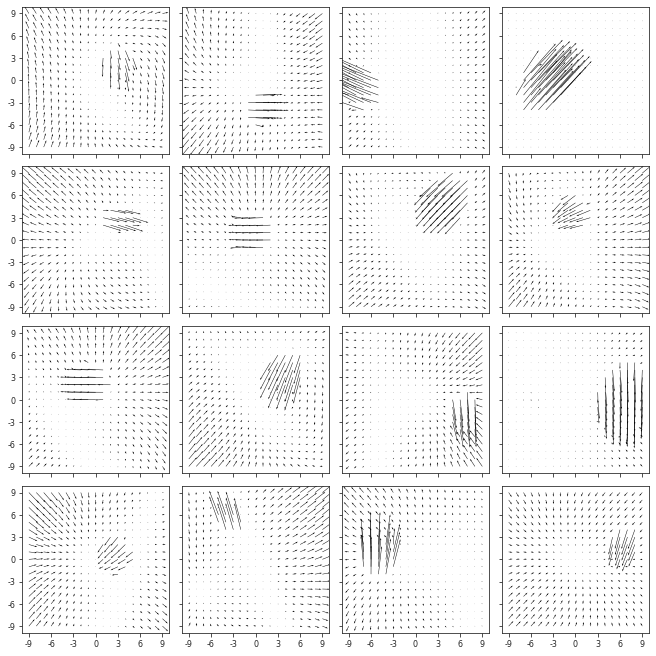

----------------------------------------------------------------------

fig/regression (VAE)

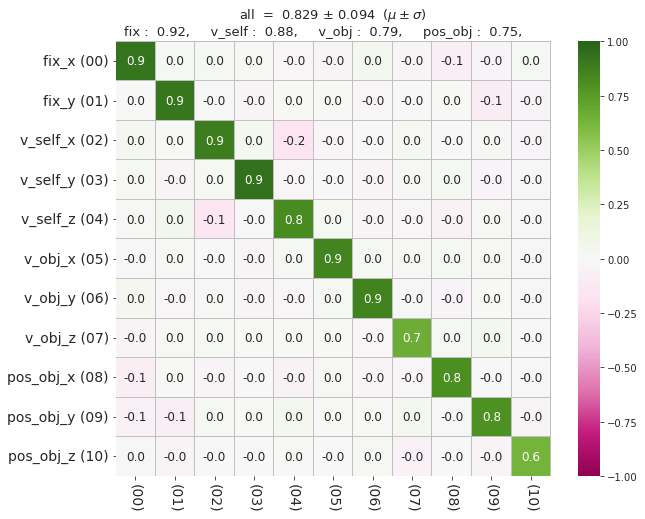

fig/regression (EMA)

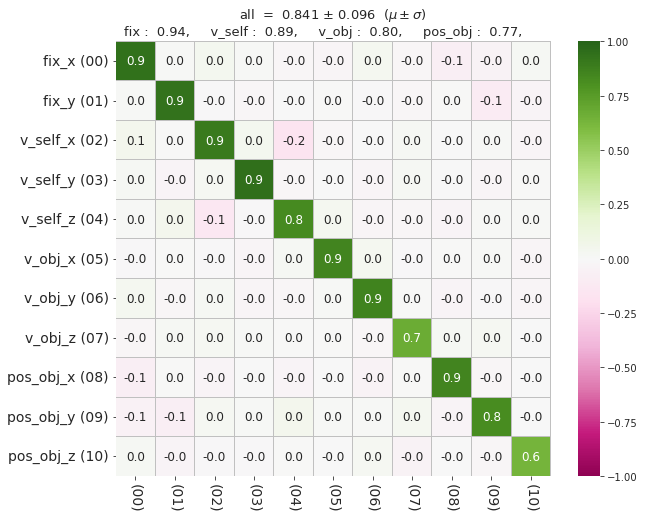

----------------------------------------------------------------------

fig/mutual_info (VAE)

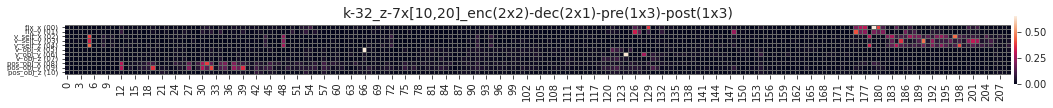

fig/mutual_info (EMA)

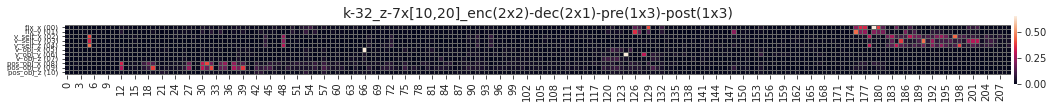

----------------------------------------------------------------------

In [6]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

## Latents hist

In [11]:
scales, _ = tr.model.latent_scales()

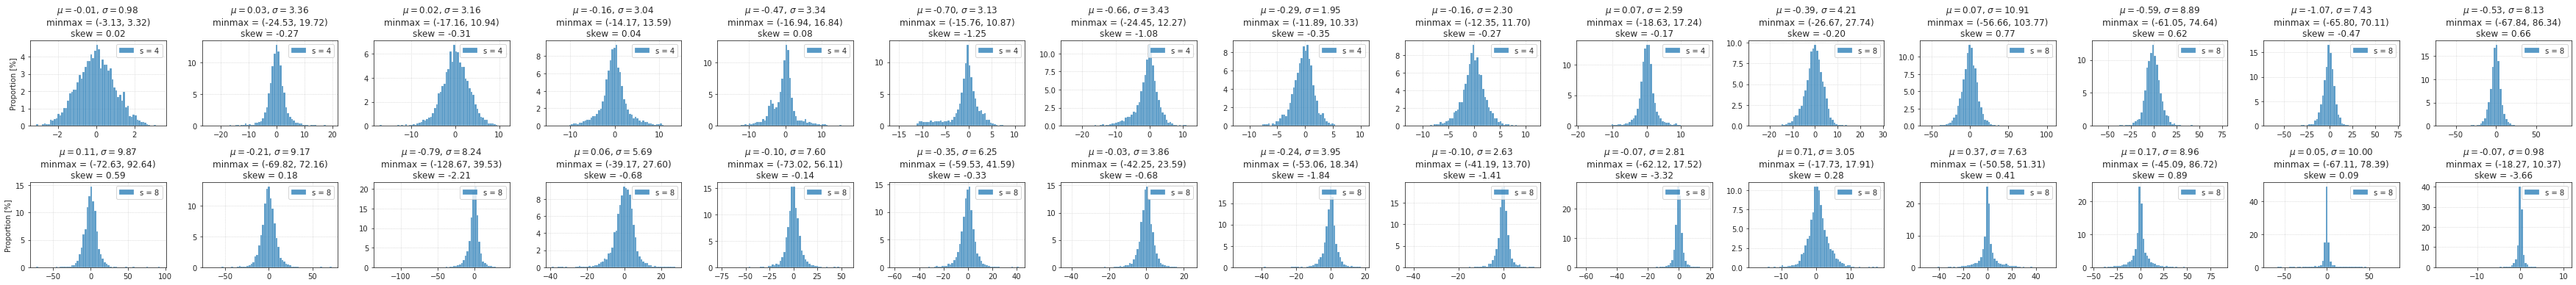

In [12]:
plot_latents_hist(val_ema['z_sample'], scales);

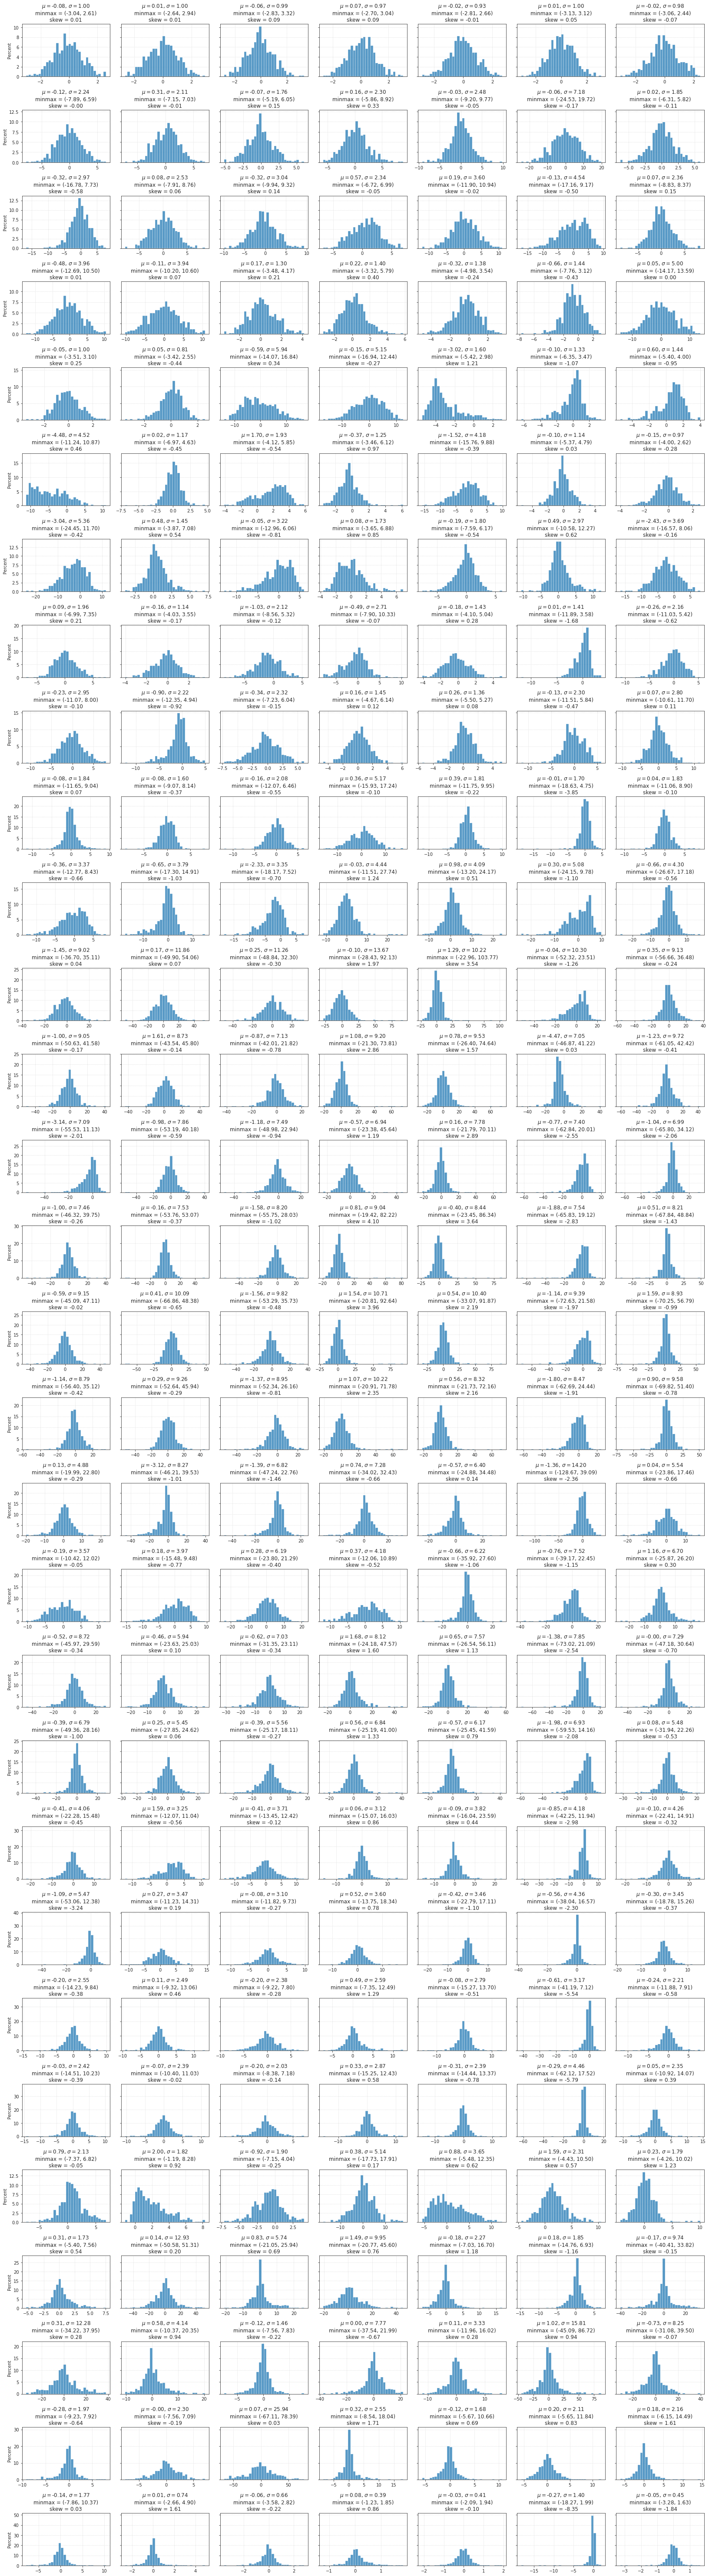

In [14]:
plot_latents_hist_full(val_ema['z_sample'], scales);

(11, 124)

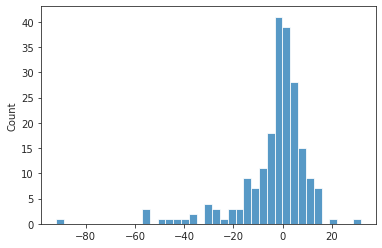

In [15]:
i, zz = np.unravel_index(np.argmin(val_ema['z_sample']), val_ema['z_sample'].shape)
sns.histplot(val['z_sample'][i]);
i, zz

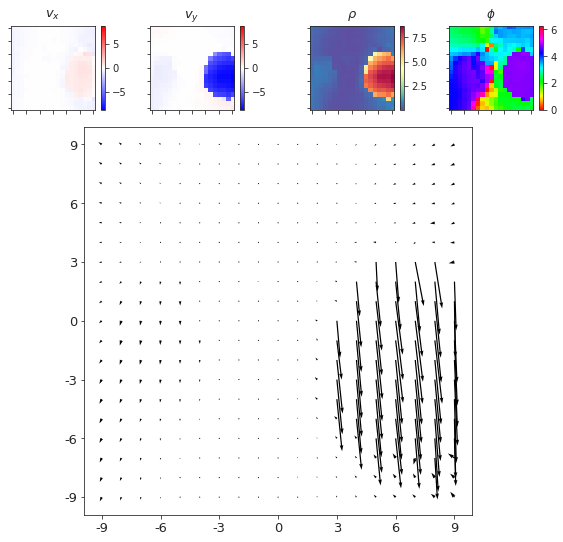

In [16]:
show_opticflow_full(val_ema['x_sample'][i]);

(129, 81)

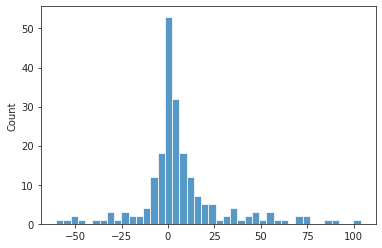

In [17]:
i, zz = np.unravel_index(np.argmax(val_ema['z_sample']), val_ema['z_sample'].shape)
sns.histplot(val_ema['z_sample'][i]);
i, zz

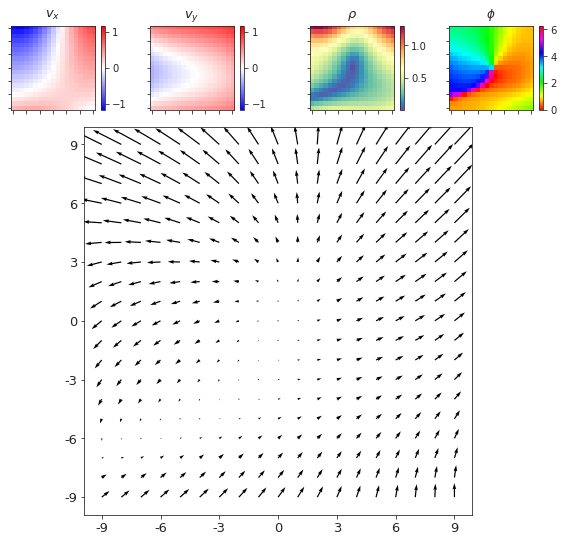

In [18]:
show_opticflow_full(val_ema['x_sample'][i]);

In [19]:
torch.abs(torch.cat(tr.model_ema.all_log_norm)).sum()

tensor(1315.3639, device='cuda:1', grad_fn=<SumBackward0>)

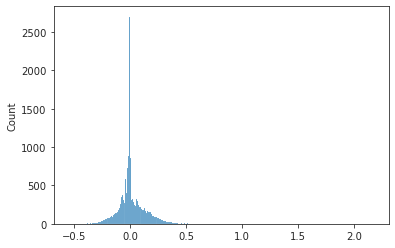

In [20]:
a = to_np(torch.cat(tr.model_ema.all_log_norm))
sns.histplot(a);

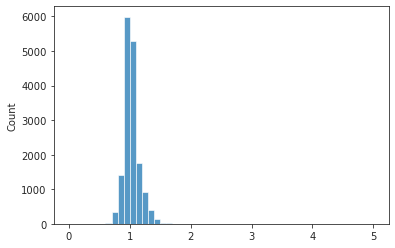

In [21]:
all_norms = to_np(torch.cat(tr.model_ema.all_log_norm).exp())
ax = sns.histplot(all_norms, bins=np.linspace(0, 5, 51));

In [22]:
np.max(all_norms)

8.75293

In [23]:
print(f"{np.round((all_norms > 1.5).sum() / len(all_norms) * 100, 1)} % of them are greated than 1.5")

0.4 % of them are greated than 1.5

In [24]:
w2p = {}
norms_expand = {}
for i, layer in enumerate(tr.model_ema.expand):
    w2p[i] = to_np(layer.weight)
    _norm = to_np(torch.linalg.vector_norm(layer.weight, dim=[0, 2, 3]))
    norms_expand[i] = list(_norm)
print({i: (np.round(np.mean(v), 3), np.round(v, 3)) for i, v in norms_expand.items()})

{
    0: (0.634, array([0.213, 0.855, 0.339, 0.81 , 0.769, 0.575, 0.875], dtype=float32)),
    1: (0.535, array([0.704, 0.504, 0.505, 0.597, 0.279, 0.616, 0.537], dtype=float32)),
    2: (0.654, array([0.759, 0.569, 0.565, 0.765, 0.731, 0.528, 0.661], dtype=float32)),
    3: (0.691, array([0.68 , 0.89 , 0.585, 0.588, 0.577, 0.855, 0.665], dtype=float32)),
    4: (0.708, array([0.638, 0.827, 0.693, 0.644, 0.818, 0.712, 0.622], dtype=float32)),
    5: (0.723, array([0.751, 0.762, 0.579, 0.733, 0.684, 0.735, 0.818], dtype=float32)),
    6: (0.701, array([0.574, 0.688, 0.771, 0.875, 0.695, 0.657, 0.649], dtype=float32)),
    7: (0.799, array([0.918, 0.856, 0.825, 0.891, 0.687, 0.749, 0.669], dtype=float32)),
    8: (0.811, array([0.932, 0.583, 0.835, 0.895, 0.963, 0.625, 0.843], dtype=float32)),
    9: (0.817, array([0.777, 0.765, 0.791, 0.76 , 0.965, 0.774, 0.887], dtype=float32)),
    10: (1.217, array([1.143, 1.03 , 1.327, 1.27 , 1.132, 1.451, 1.167], dtype=float32)),
    11: (1.217, array([1.29 , 1.277, 1.299, 1.129, 1.126, 1.184, 1.218], dtype=float32)),
    12: (1.279, array([1.307, 1.039, 1.184, 1.278, 1.408, 1.364, 1.373], dtype=float32)),
    13: (1.219, array([1.262, 1.288, 1.186, 0.9  , 1.284, 1.348, 1.264], dtype=float32)),
    14: (1.218, array([0.923, 1.278, 1.291, 1.301, 1.205, 1.214, 1.311], dtype=float32)),
    15: (1.178, array([1.17 , 1.094, 1.059, 1.292, 1.265, 1.051, 1.313], dtype=float32)),
    16: (1.137, array([1.167, 0.889, 1.382, 1.289, 0.974, 1.289, 0.973], dtype=float32)),
    17: (1.447, array([1.4  , 1.457, 1.468, 1.499, 1.432, 1.458, 1.412], dtype=float32)),
    18: (1.313, array([1.32 , 1.162, 1.137, 1.465, 1.27 , 1.425, 1.409], dtype=float32)),
    19: (1.113, array([1.001, 1.084, 1.099, 1.355, 1.346, 1.012, 0.899], dtype=float32)),
    20: (1.131, array([1.266, 1.104, 1.238, 0.744, 1.487, 1.167, 0.916], dtype=float32)),
    21: (1.173, array([1.566, 1.398, 1.125, 1.096, 0.825, 1.281, 0.92 ], dtype=float32)),
    22: (1.208, array([1.065, 1.276, 1.291, 1.187, 1.009, 1.49 , 1.136], dtype=float32)),
    23: (1.231, array([0.974, 1.6  , 1.144, 1.304, 1.292, 1.203, 1.101], dtype=float32)),
    24: (1.185, array([1.079, 1.371, 1.3  , 0.889, 1.184, 1.362, 1.107], dtype=float32)),
    25: (1.465, array([1.501, 1.326, 1.436, 1.53 , 1.519, 1.411, 1.529], dtype=float32)),
    26: (1.244, array([1.53 , 1.175, 1.226, 1.188, 1.229, 1.183, 1.178], dtype=float32)),
    27: (1.448, array([1.523, 1.529, 1.342, 1.508, 1.439, 1.415, 1.384], dtype=float32)),
    28: (1.429, array([1.386, 1.381, 1.471, 1.331, 1.592, 1.452, 1.393], dtype=float32)),
    29: (1.144, array([1.197, 1.193, 1.14 , 0.832, 1.202, 1.235, 1.21 ], dtype=float32))
}

In [25]:
tr.model_ema.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  17.0 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |   96.0 K   |
|  enc_tower  |  9.4 Mil   |
|     enc0    |   16.6 K   |
| enc_sampler |  1.4 Mil   |
| dec_sampler |  1.4 Mil   |
|    expand   |   71.0 K   |
|  dec_tower  |  4.5 Mil   |
|     post    |   40.0 K   |
|     out     |    578     |
+-------------+------------+

In [26]:
tr.model_ema.stem.lognorm.exp()

tensor([1.0529, 1.0926, 1.0503, 1.0966, 1.0708, 1.0900, 1.0637, 1.2509, 1.0895,
        1.0335, 1.0647, 1.1535, 1.0952, 1.0680, 1.1739, 1.1013, 1.0969, 1.2078,
        1.3752, 1.2252, 1.1089, 1.0698, 1.1477, 1.0786, 1.0759, 1.0658, 1.1137,
        1.0880, 1.0726, 1.0691, 1.1349, 1.0926], device='cuda:1',
       grad_fn=<ExpBackward0>)

In [27]:
w = to_np(tr.model_ema.out.weight)
w.shape

(2, 32, 3, 3)

In [28]:
torch.linalg.vector_norm(tr.model_ema.out.weight, dim=[1, 2, 3])

tensor([0.2505, 0.2539], device='cuda:1', grad_fn=<LinalgVectorNormBackward0>)

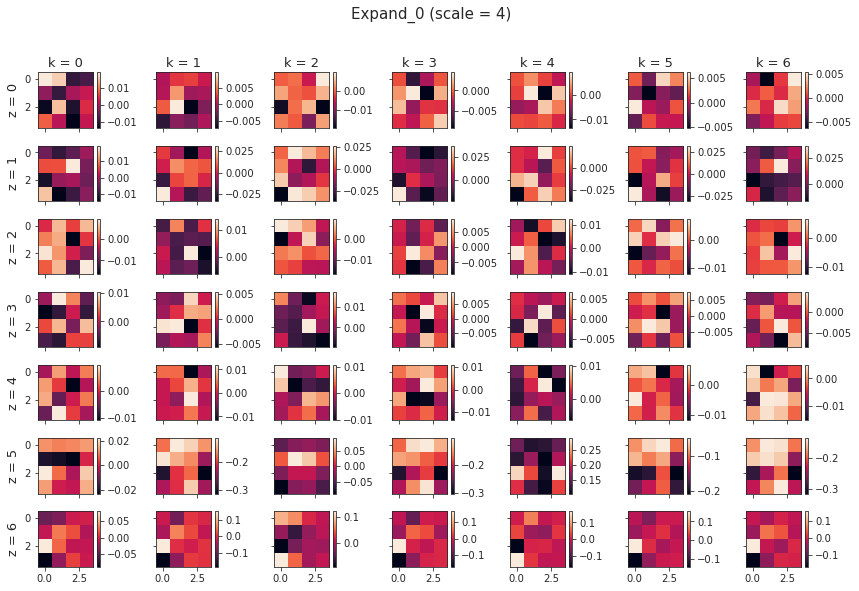

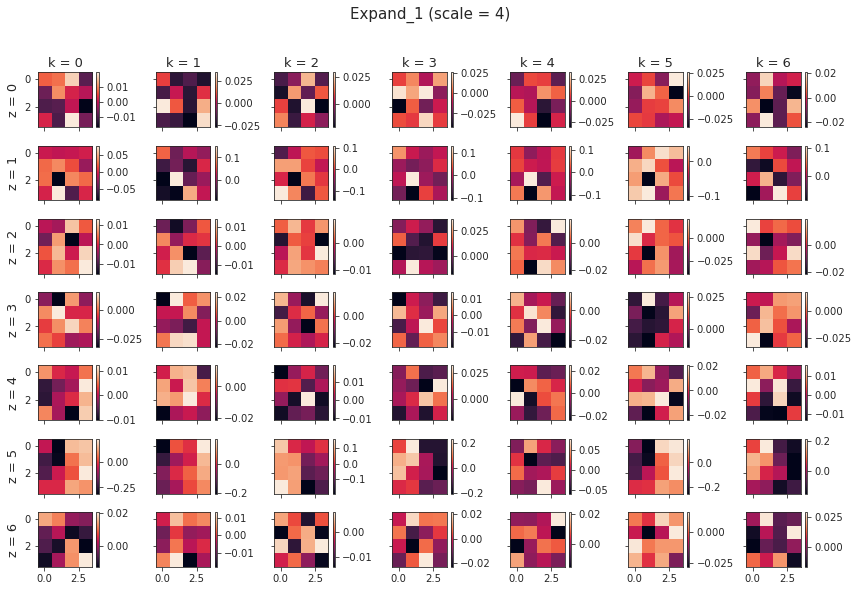

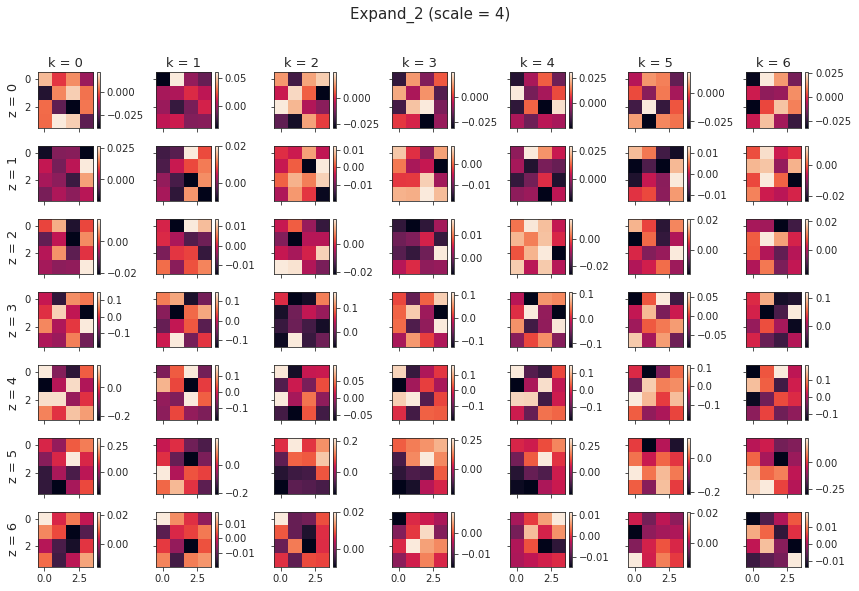

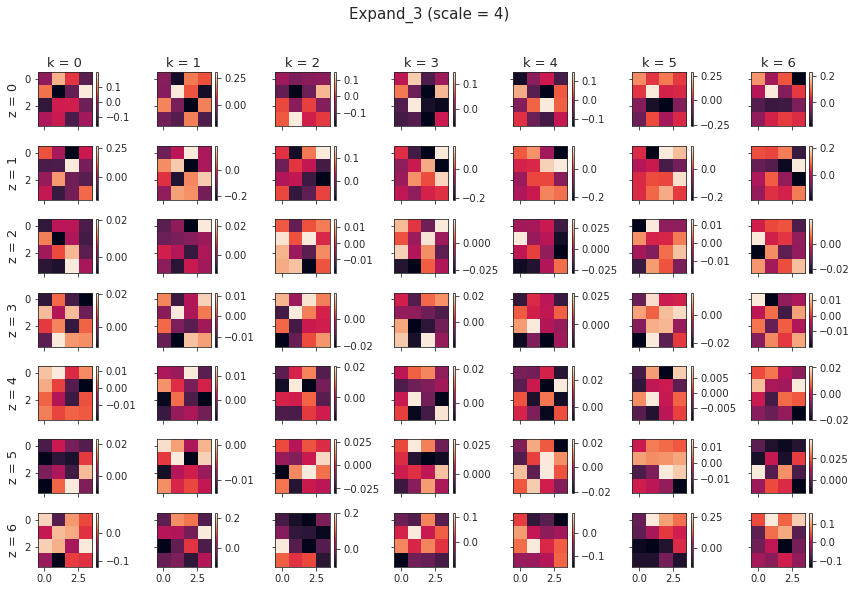

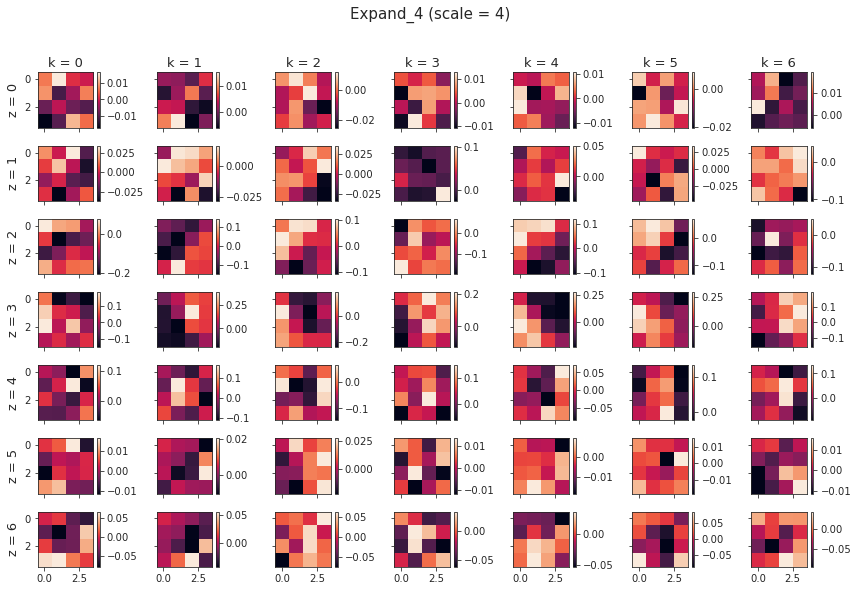

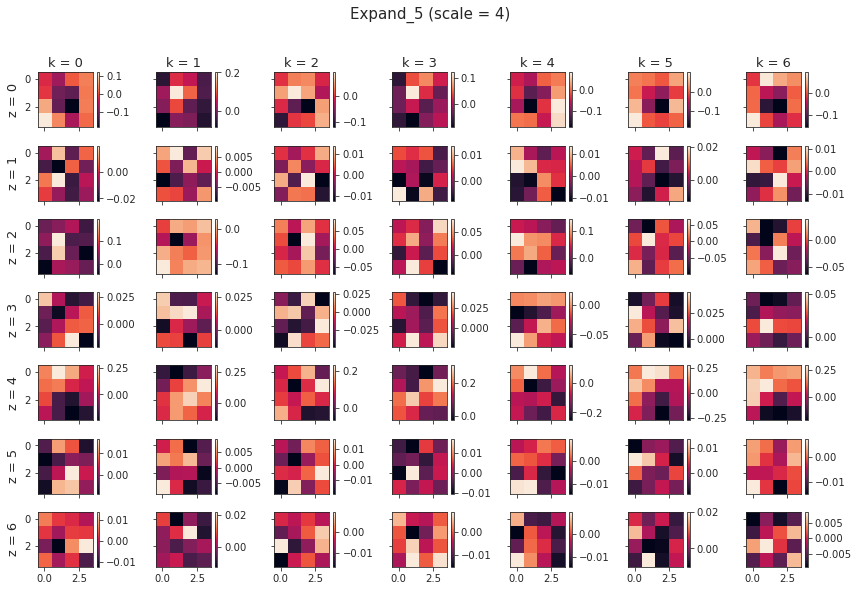

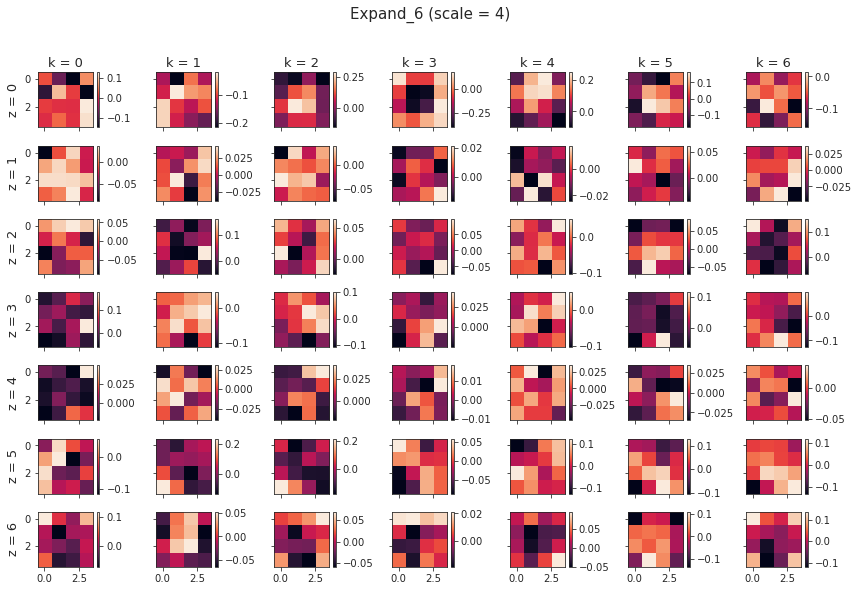

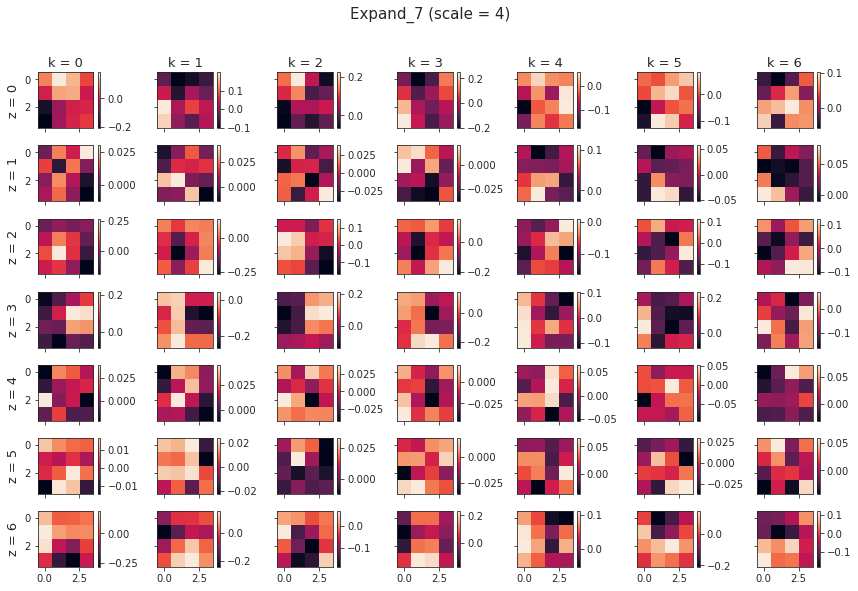

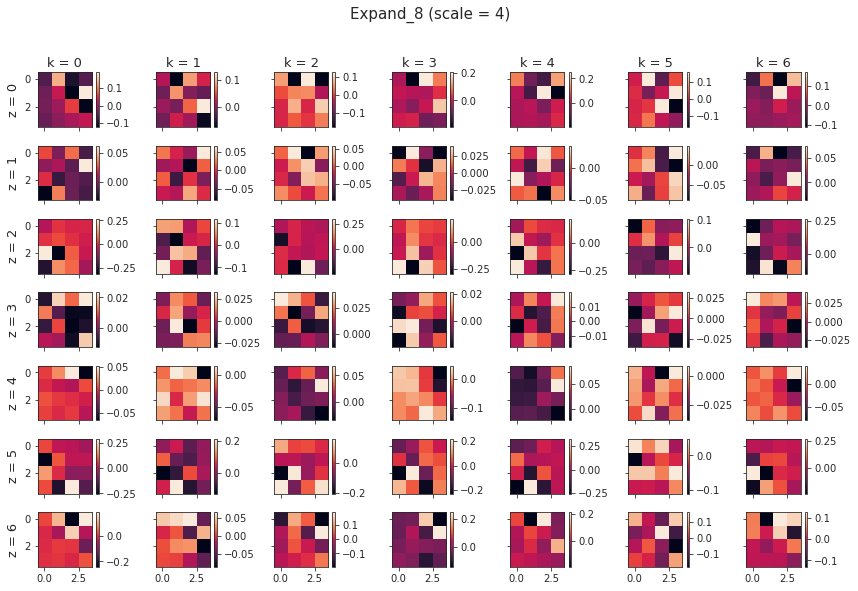

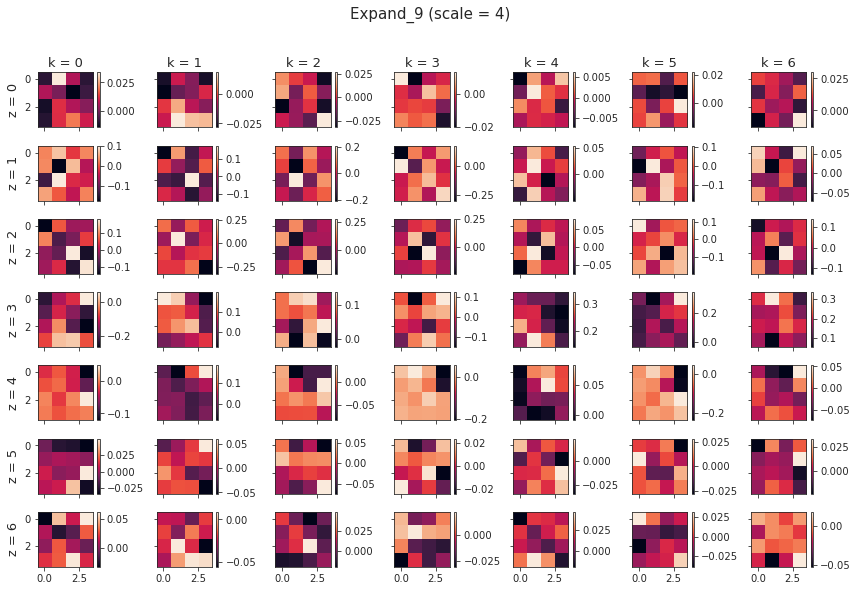

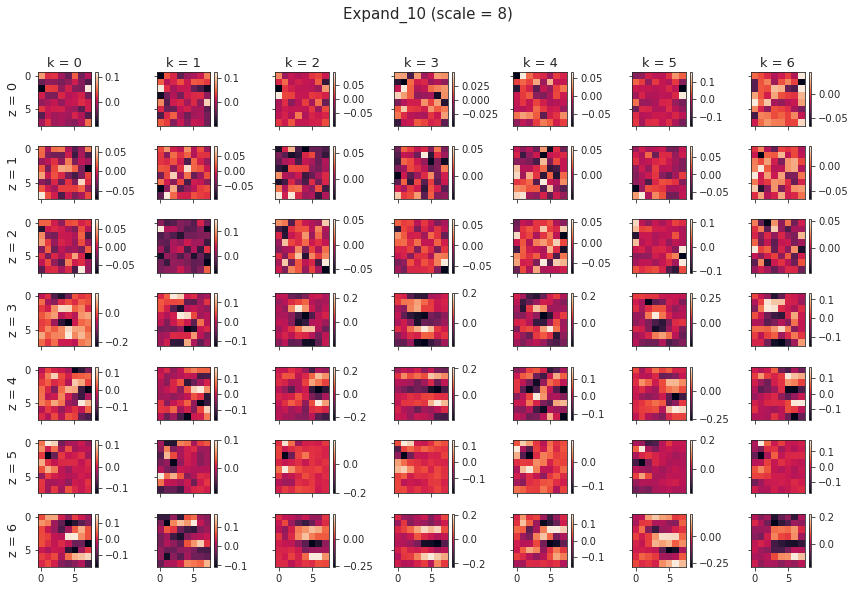

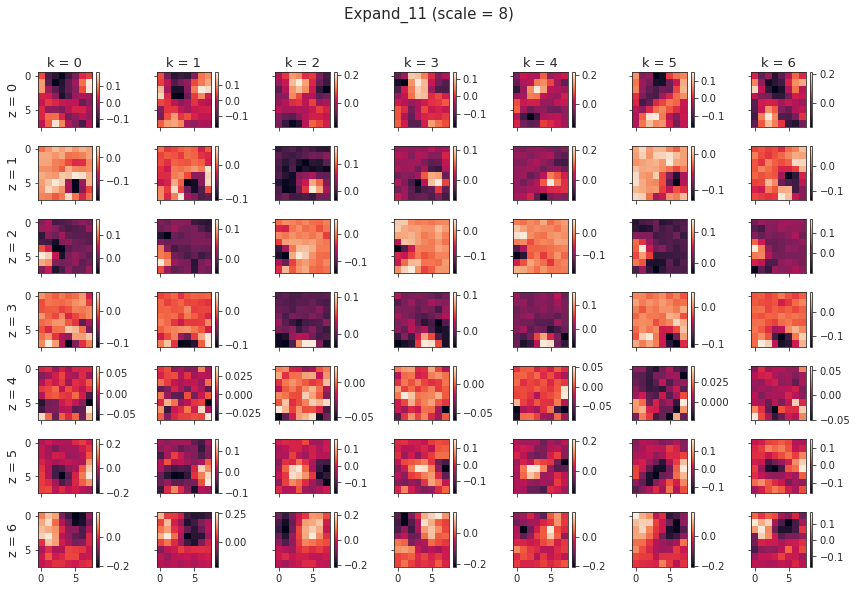

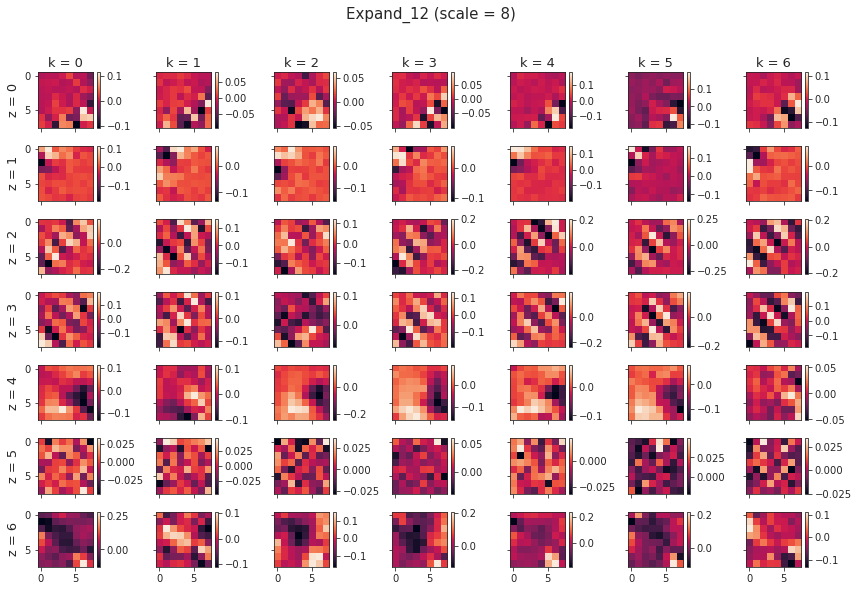

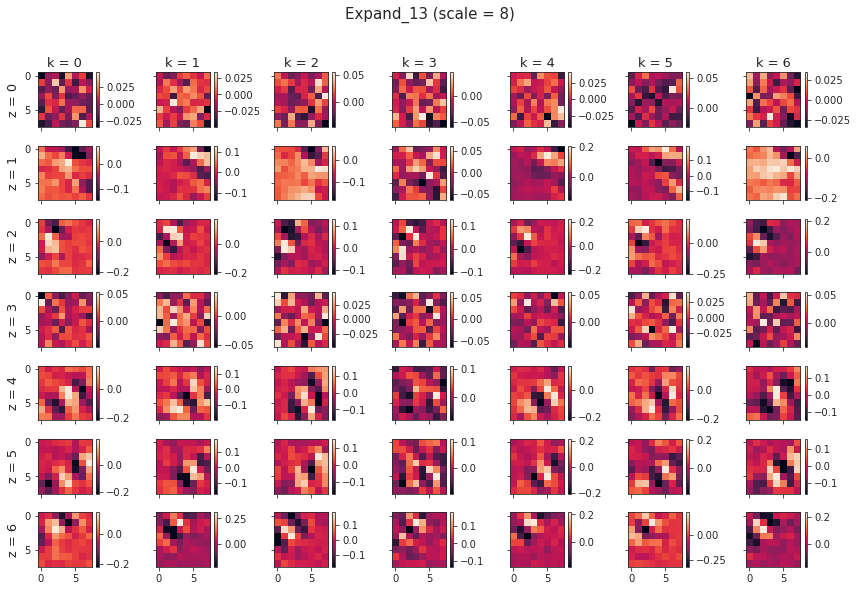

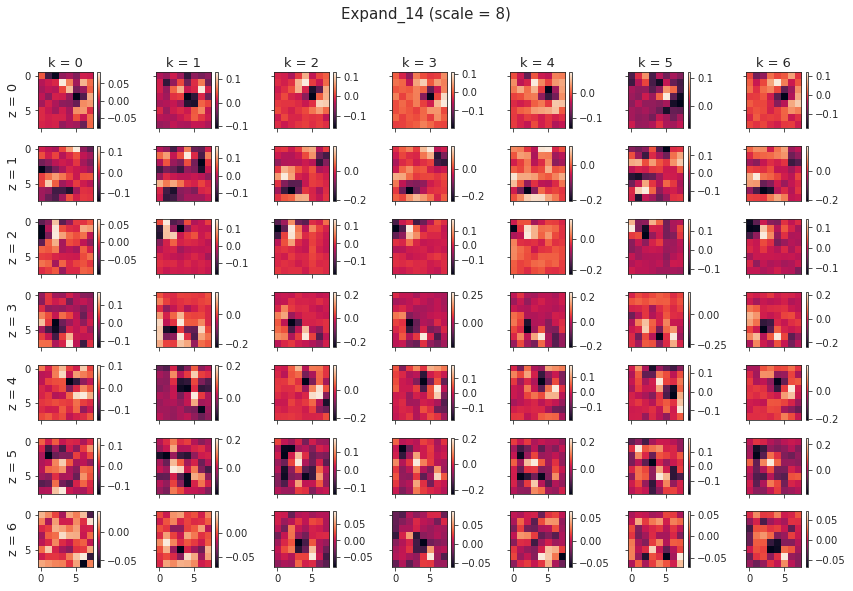

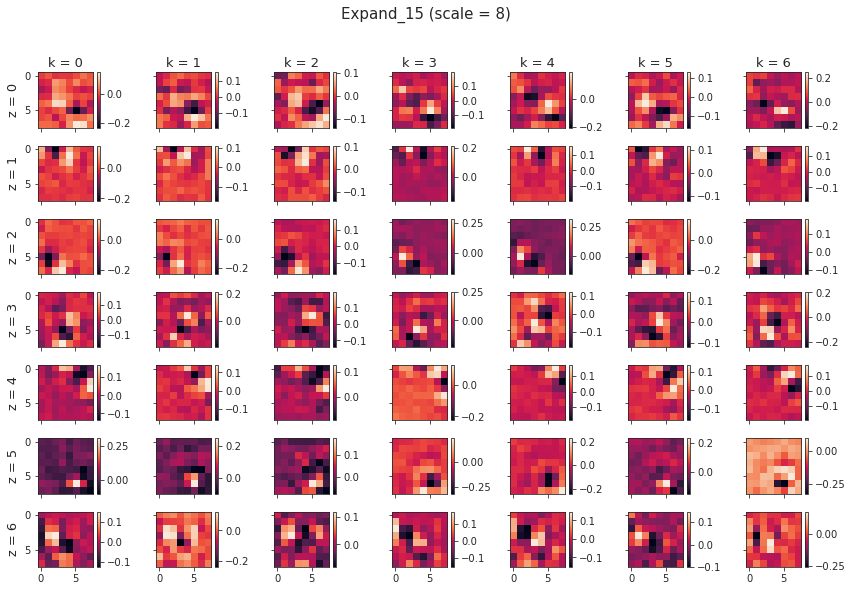

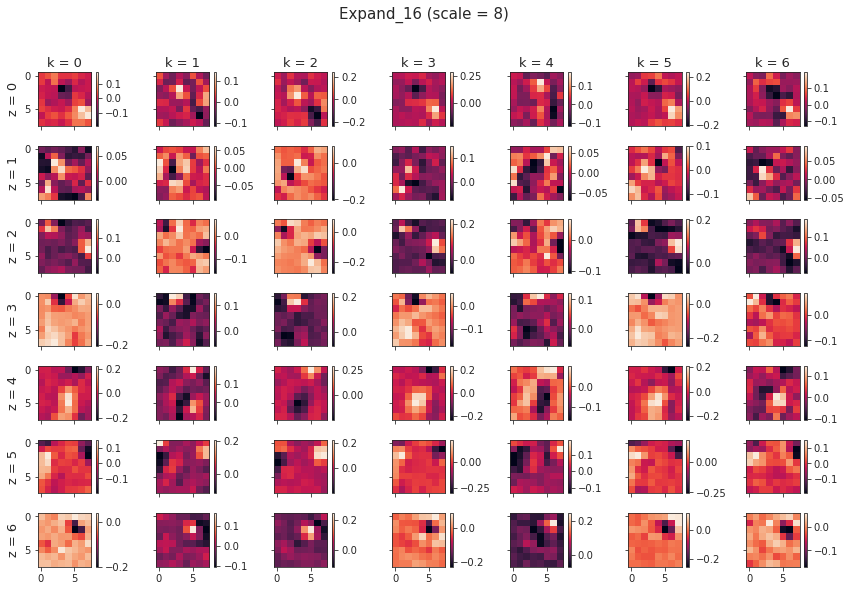

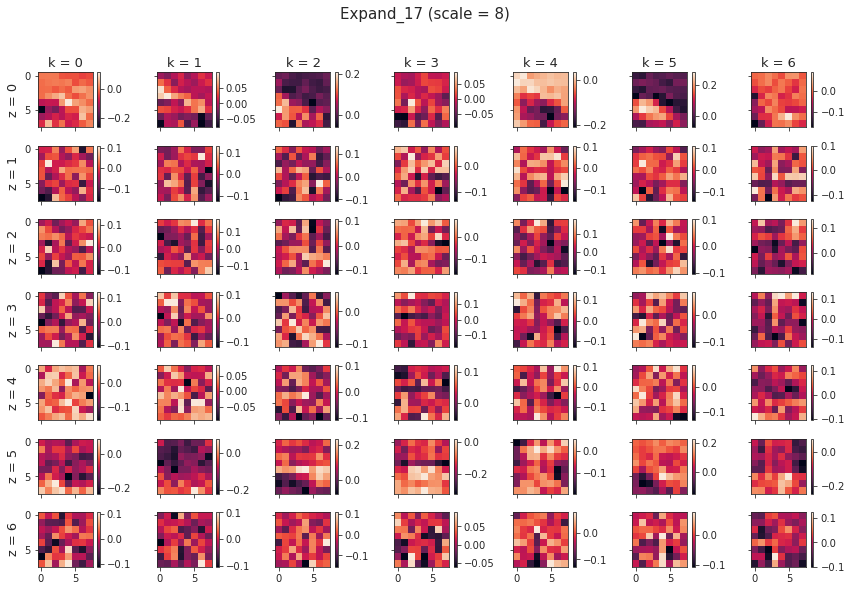

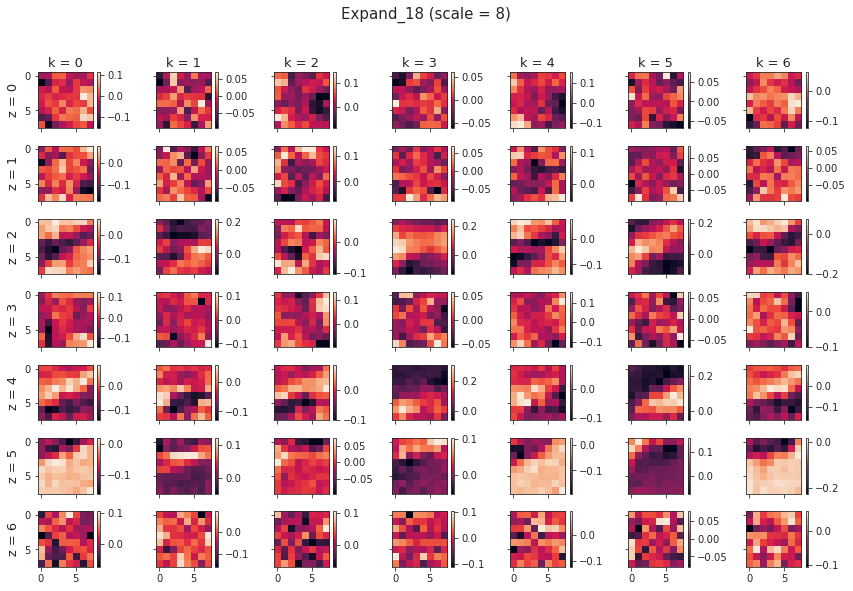

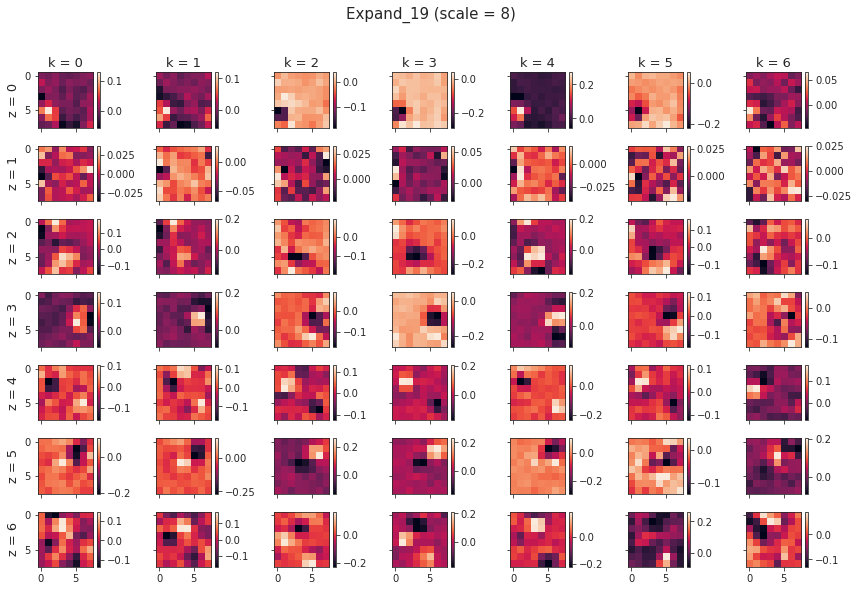

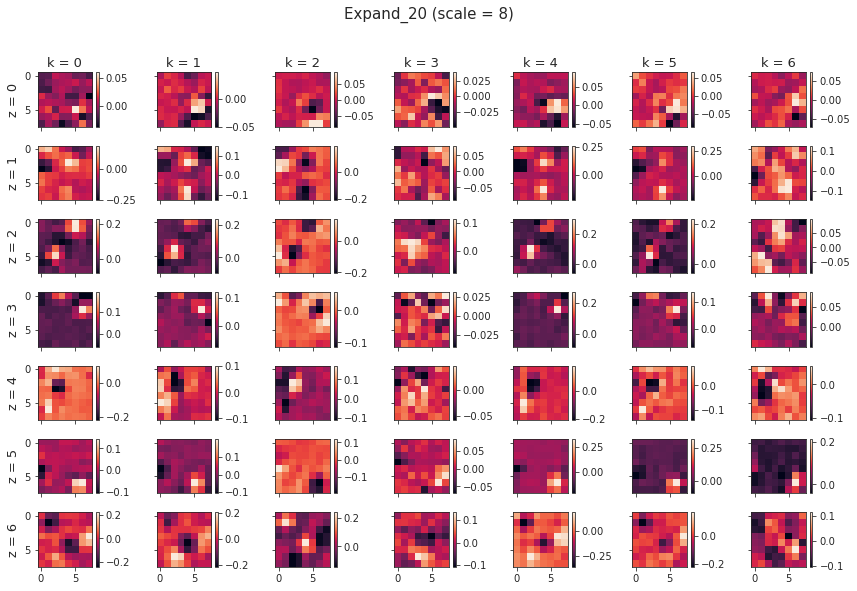

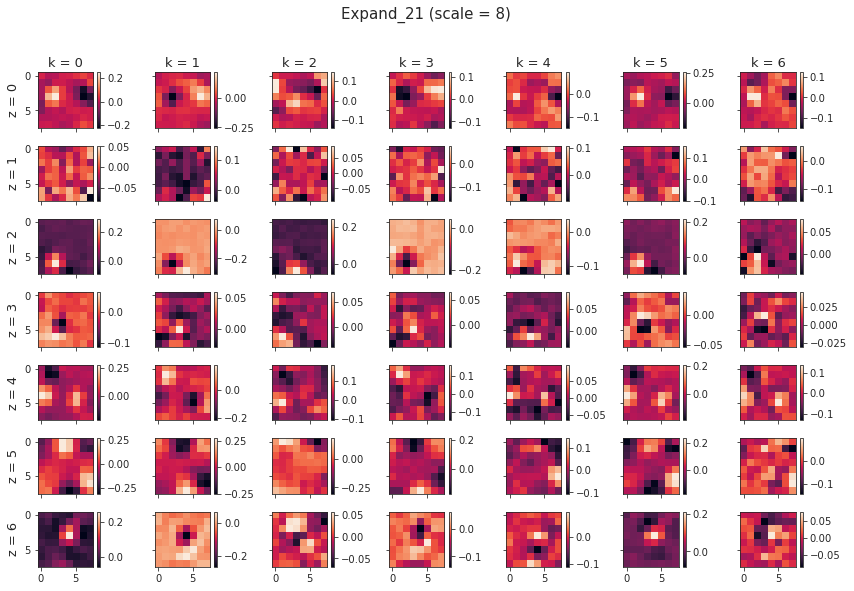

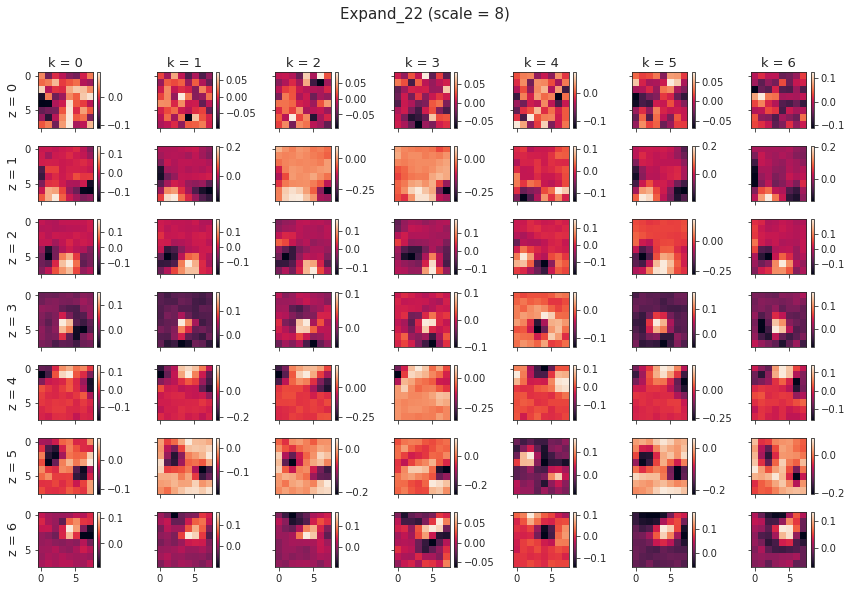

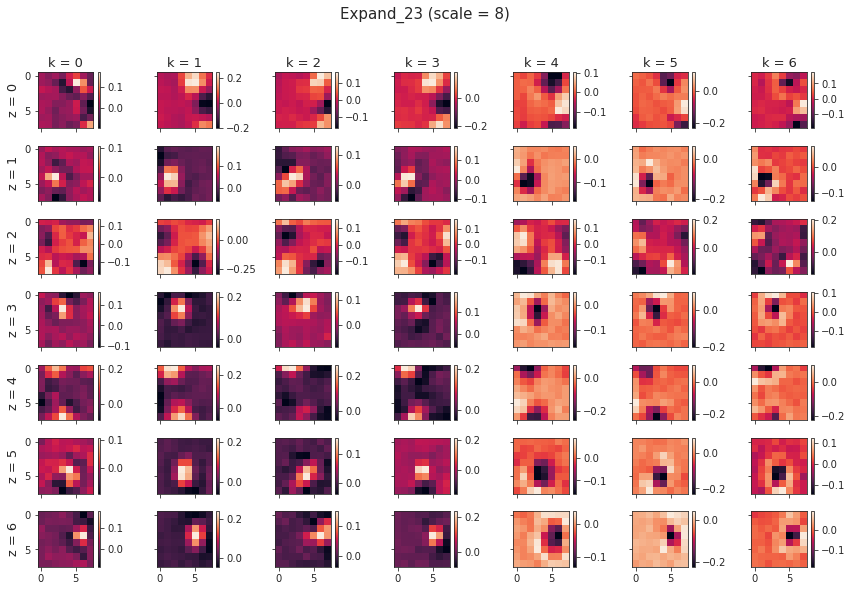

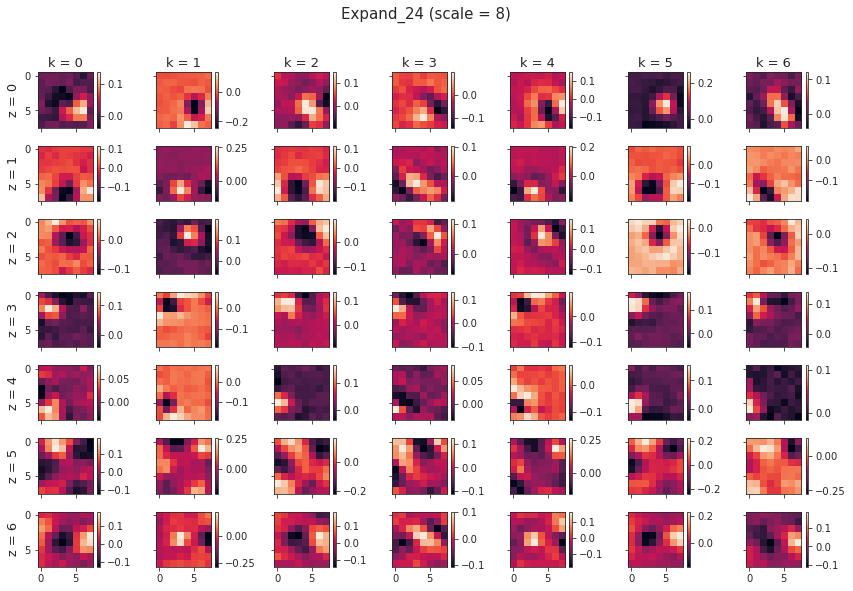

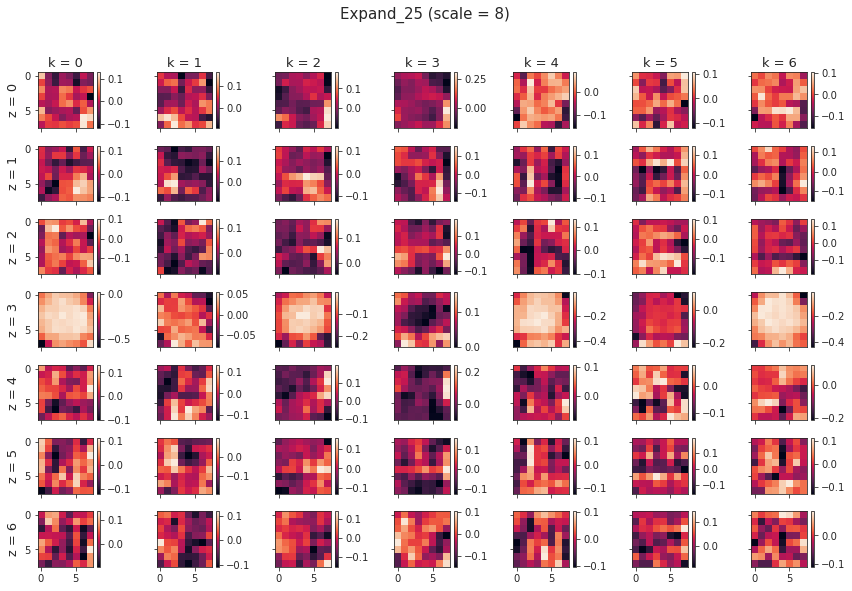

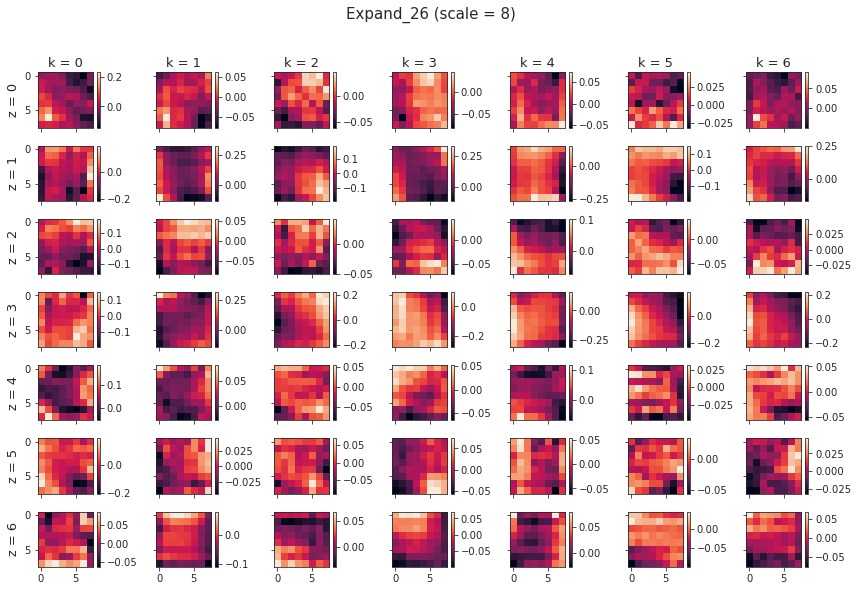

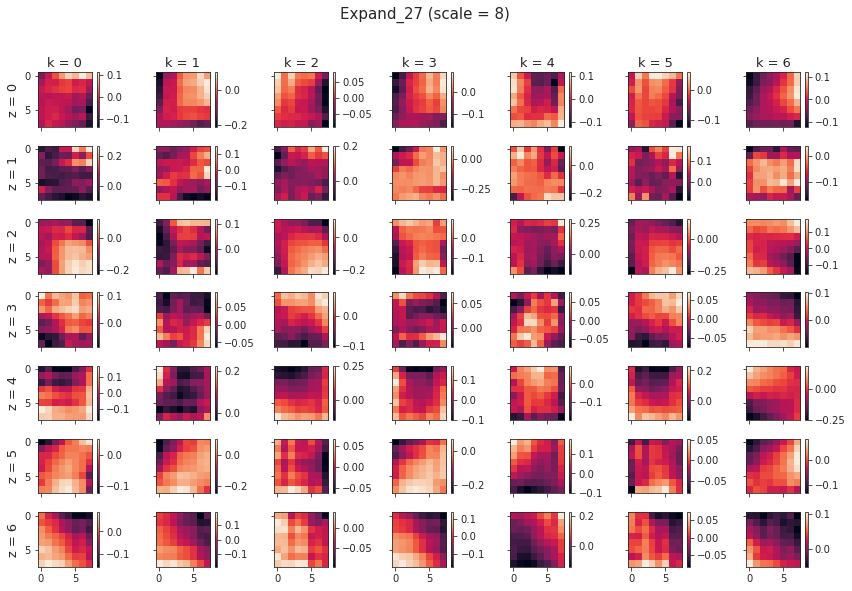

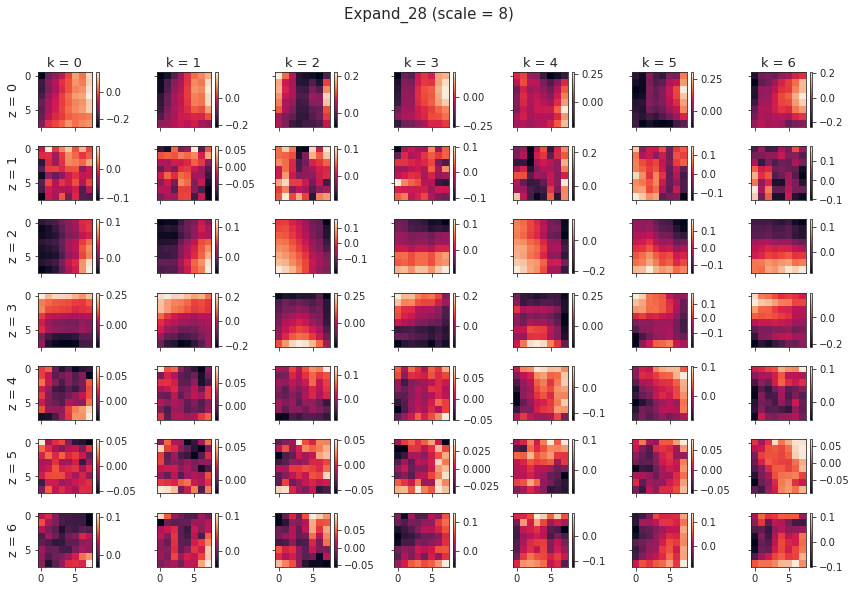

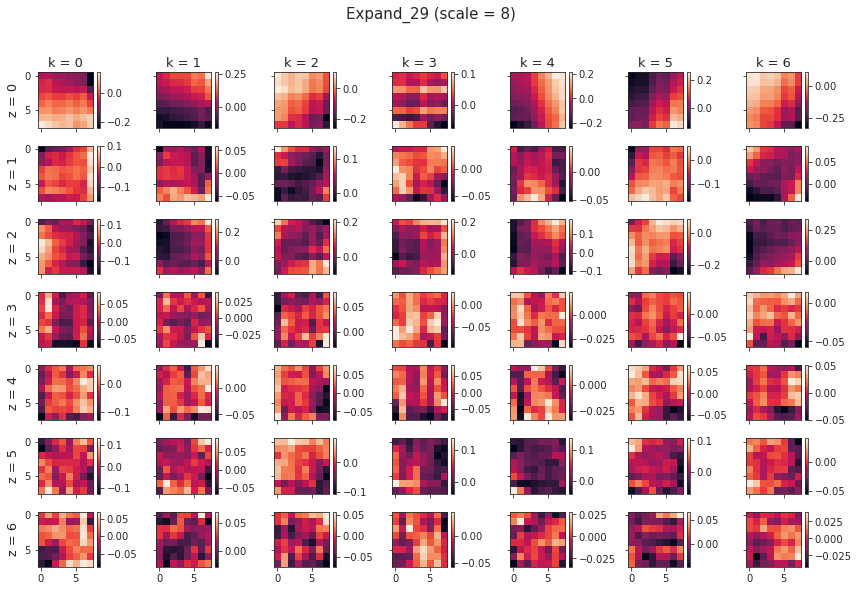

In [94]:
scales, _ = tr.model.latent_scales()
num = tr.model.cfg.n_latent_per_group

for i, _w in w2p.items():
    fig, axes = create_figure(num, num, (12, 8), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        im = ax.imshow(_w[z, k])
        plt.colorbar(im, ax=ax)
        if z == 0:
            ax.set_title(f"k = {k}", fontsize=13)
        if k == 0:
            ax.set_ylabel(f"z = {z}", fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()

## TMP: def r(self, x):

In [7]:
from model.common import endpoint_error
from model.distributions import Normal
from model.vae2d import CombinerEnc, CombinerDec

In [9]:
x, norm = next(iter(tr.dl_tst))
z, ftr_enc, ftr_dec, y, q, p = tr.model_ema.xtract_ftr(x, t=0)

nf_enc = {s: len(f) for s, f in ftr_enc.items()}
nf_dec = {s: len(f) for s, f in ftr_dec.items()}
print(f"num ftrs enc: {nf_enc}\nnum ftrs dec: {nf_dec}")

num ftrs enc: {8: 40, 4: 21}
num ftrs dec: {4: 18, 8: 41}

In [10]:
endpoint_error(x, y).mean()

tensor(1.6867, device='cuda:1')

In [12]:
e8 = np.concatenate(ftr_enc[8], 1)
d8 = np.concatenate(ftr_dec[8], 1)
e4 = np.concatenate(ftr_enc[4], 1)
d4 = np.concatenate(ftr_dec[4], 1)
e8.shape, d8.shape, e4.shape, d4.shape

((512, 2560, 8, 8), (512, 2624, 8, 8), (512, 2688, 4, 4), (512, 2304, 4, 4))

In [24]:
len(ftr_enc[8]), len(ftr_dec[8])

(40, 41)

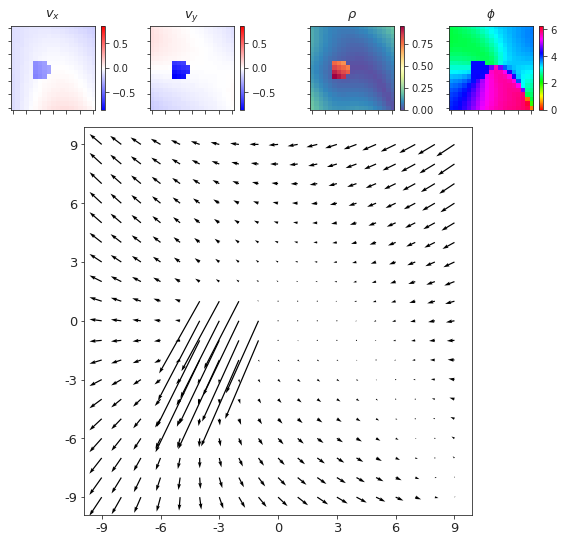

In [34]:
i = 0
show_opticflow_full(x[i]);

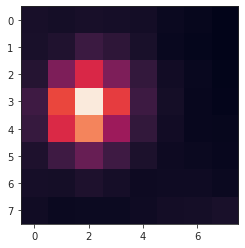

In [35]:
plt.imshow(np.abs(e8[i]).mean(0))

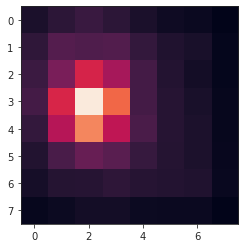

In [36]:
plt.imshow(np.abs(d8[i]).mean(0))

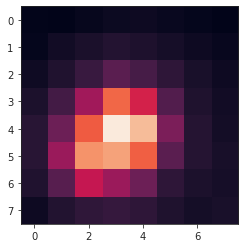

In [77]:
plt.imshow(np.abs(r8[i]).mean(0))

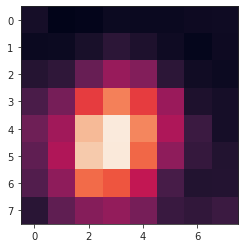

In [78]:
plt.imshow(np.maximum(0, r8[i]).mean(0))

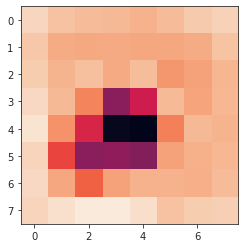

In [79]:
plt.imshow(r8[i].mean(0))

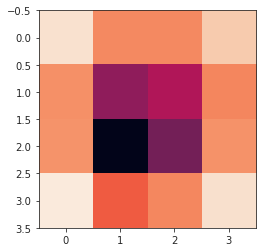

In [80]:
plt.imshow(r4[i].mean(0))

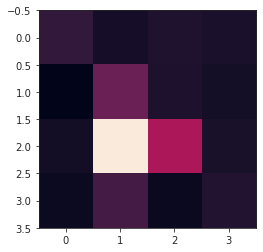

In [81]:
plt.imshow(np.maximum(0, r4[i]).mean(0))

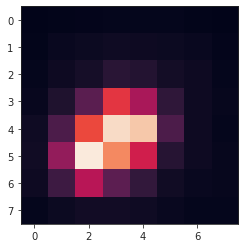

In [82]:
plt.imshow(r8[i].var(0))

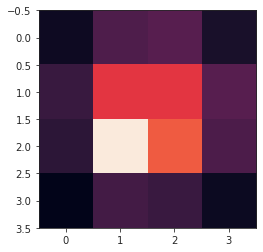

In [83]:
plt.imshow(r4[i].var(0))

In [37]:
e8.shape, d8.shape

((512, 2560, 8, 8), (512, 2624, 8, 8))

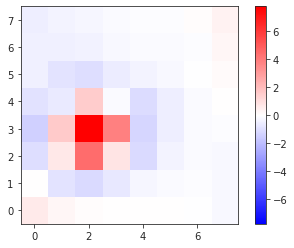

In [70]:
x2p = e8[i, 250]
vminmax = np.max(np.abs(x2p))
fig, ax = create_figure()
im = ax.imshow(x2p, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

In [71]:
x2p.shape

(8, 8)

In [72]:
np.argsort(np.abs(d8[i] - np.expand_dims(x2p, 0)).sum(-1).sum(-1))

array([2036, 2100, 1940, ...,   31,   95,  159])

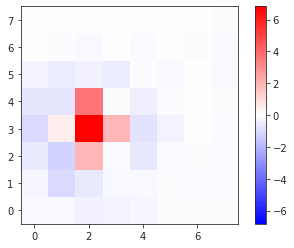

In [74]:
x2p = d8[i, 2100]
vminmax = np.max(np.abs(x2p))
fig, ax = create_figure()
im = ax.imshow(x2p, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

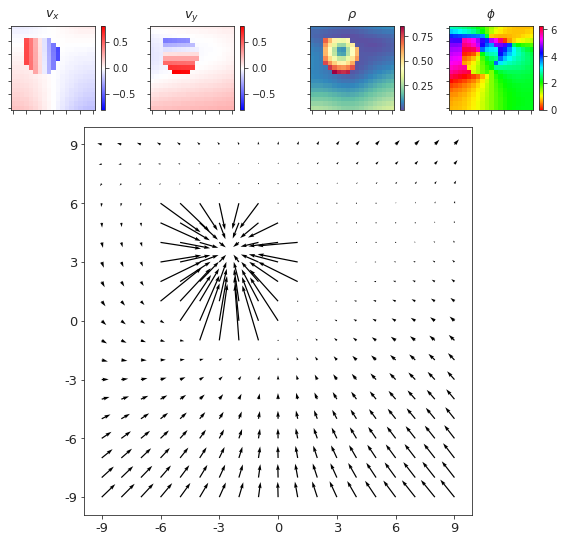

In [120]:
show_opticflow_full(x[7]);

In [137]:
def repres(
        self,
        dl: str,
        t: float = 0,
        use_ema: bool = False, ):
    assert dl in ['trn', 'vld', 'tst']
    dl = getattr(self, f"dl_{dl}")
    if dl is None:
        return
    model = self.select_model(use_ema)

    x_all, y_all, z_all = [], [], []
    l1, l2, epe, kl = [], [], [], []
    for i, (x, norm) in enumerate(dl):
        if x.device != self.device:
            x, norm = self.to([x, norm])
        _, z, *_ = model.xtract_ftr(x, t=t)
        z = torch.cat(z, dim=1).squeeze()
        z_all.append(to_np(z))

    return np.concatenate(z_all)

In [138]:
%%time

z_tst = repres(tr, 'tst', True)
z_vld = repres(tr, 'vld', True)

CPU times: user 6.91 s, sys: 632 ms, total: 7.54 s
Wall time: 7.54 s


In [82]:
g_vld = tr.dl_vld.dataset.factors
g_tst = tr.dl_tst.dataset.factors

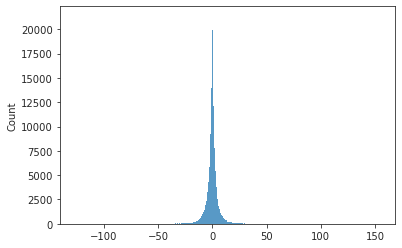

In [140]:
sns.histplot(z_vld.ravel());

In [141]:
z_vld.shape

(7500, 210)

In [142]:
# from analysis.regression import regress
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression

def regress(z, g, z_tst, g_tst):
    # mi regression
    mi = np.zeros((g.shape[-1], z.shape[-1]))
    # for i in range(len(mi)):
    #     mi[i] = mutual_info_regression(z, g[:, i])
    # linear regression
    lr = linear_model.LinearRegression().fit(z, g)
    r = 1 - sp_dist.cdist(
        XA=g_tst.T,
        XB=lr.predict(z_tst).T,
        metric='correlation',
    )
    return mi, r, lr

mi, rr, lr = regress(z_vld, g_vld, z_tst, g_tst)

In [143]:
np.diag(rr)

array([0.92512674, 0.90689993, 0.87940288, 0.9281913 , 0.8212474 ,
       0.85449239, 0.87752674, 0.70255081, 0.87056153, 0.8422471 ,
       0.64396748])

In [76]:
np.diag(val_ema['regr/r'])

array([0.94135484, 0.92973866, 0.90059408, 0.94560584, 0.82830015,
       0.85378562, 0.86509301, 0.67792185, 0.8526114 , 0.82099003,
       0.6394755 ])

In [85]:
%%time

n_fwd = 10
use_ema = True
z_vld, z_tst = [], []
for _ in range(n_fwd):
    zv = tr.forward('vld', False, use_ema)[0]['z']
    zt = tr.forward('tst', False, use_ema)[0]['z']
    z_vld.append(np.expand_dims(zv, 0))
    z_tst.append(np.expand_dims(zt, 0))
    
z_vld, z_tst = cat_map([z_vld, z_tst])
z_vld = z_vld.mean(0)
z_tst = z_tst.mean(0)

CPU times: user 40 s, sys: 5.02 s, total: 45 s
Wall time: 44.9 s


In [89]:
mi, rr, lr = regress(z_vld, g_vld, z_tst, g_tst)

In [90]:
np.diag(rr)

array([0.94240732, 0.93018334, 0.89773044, 0.94760517, 0.8267325 ,
       0.85470746, 0.86887434, 0.68998536, 0.85006285, 0.83255921,
       0.63718095])

In [91]:
np.diag(val_ema['regr/r'])

array([0.94135484, 0.92973866, 0.90059408, 0.94560584, 0.82830015,
       0.85378562, 0.86509301, 0.67792185, 0.8526114 , 0.82099003,
       0.6394755 ])

In [92]:
%%time

n_fwd = 100
use_ema = True
z_vld, z_tst = [], []
for _ in range(n_fwd):
    zv = tr.forward('vld', False, use_ema)[0]['z']
    zt = tr.forward('tst', False, use_ema)[0]['z']
    z_vld.append(np.expand_dims(zv, 0))
    z_tst.append(np.expand_dims(zt, 0))
    
z_vld, z_tst = cat_map([z_vld, z_tst])
z_vld = z_vld.mean(0)
z_tst = z_tst.mean(0)

CPU times: user 6min 51s, sys: 58.2 s, total: 7min 49s
Wall time: 7min 49s


In [93]:
mi, rrr, lr = regress(z_vld, g_vld, z_tst, g_tst)
np.diag(rrr)

array([0.94564019, 0.93695063, 0.90010376, 0.9475873 , 0.82723381,
       0.86777176, 0.88216196, 0.73312985, 0.86586815, 0.84687005,
       0.68640429])

In [94]:
np.diag(rrr).mean()

0.8581565229504179

In [96]:
np.diag(val_ema['regr/r']).mean()

0.8414064524314434